In [1]:
import numpy as np

# Predicting credit default
This dataset includes 30000 observations and whether or not they defaulted on their credit card. Observations include data such as credit limit, age, sex, highest education reached, and marital status. The dataset was obtained from the Tests section of Yellowbrick.

In [2]:
import os
import zipfile
import requests
from sklearn.svm import LinearSVC
import numpy.matlib
from yellowbrick.classifier import ROCAUC

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def add_column(data_array,new_column):
    nc = numpy.reshape(new_column,(-1,1))
    if data_array is None:
        return nc
    else:
        return numpy.concatenate((data_array,nc),axis=1)

In [4]:
def add_categorical(data_array,new_column,datatype):
    nc = numpy.reshape(new_column,(-1,1))
    unq = numpy.unique(new_column)
    nrows = numpy.size(new_column)
    new_columns = None

    for y in unq:
        newcol = numpy.zeros((nrows,1),dtype=datatype)
        newcol[numpy.where(nc==y)] = 1
        if new_columns is None:
            new_columns = newcol
        else:
            new_columns = numpy.concatenate((new_columns,newcol),axis=1)

    if data_array is None:
        return new_columns
    else:
        return numpy.concatenate((data_array,new_columns),axis=1)

In [5]:
creditdata_info = {
        'url': 'https://s3.amazonaws.com/ddl-data-lake/yellowbrick/credit.zip',
        'signature': '4a91339c69f55e18f3f48004328fbcb7868070b618208fed099920427b084e5e',
        'type': 'numpy',
    }

In [6]:
path = os.getcwd()
response = requests.get(creditdata_info['url'], stream=True)
dlpath = 'creditdata.zip'
with open(dlpath, 'wb') as f:
    for chunk in response.iter_content(65536):
        f.write(chunk)

In [7]:
zf = zipfile.ZipFile(dlpath)
zf.extractall(path)

In [8]:
credittxt_path = os.path.join(path,'credit','credit.csv')
credit = np.genfromtxt(credittxt_path, dtype=float, delimiter=',', names=True)

In [9]:
credit_keys = credit.dtype.names
datatype = credit.dtype[0]
ncols = len(credit_keys)
categorical_names = ['edu','married']
y_name = 'default'
credit_data = None
for j in range(0,ncols):
    if credit_keys[j] in categorical_names:
        credit_data = add_categorical(credit_data,credit[credit_keys[j]],datatype)
    elif credit_keys[j] == y_name:
        y = credit[y_name].astype(int)
    else:
        credit_data = add_column(credit_data,credit[credit_keys[j]])

In [10]:
#Rescale the dataset by subtracting the mean from each column and dividing by the standard deviation
datashape = credit_data.shape
nrows = datashape[0]
cmeans = np.mean(credit_data,0)
repmeans = numpy.matlib.repmat(cmeans,nrows,1)
mydata = credit_data - repmeans
sstds = np.std(mydata,0)
repstds = numpy.matlib.repmat(sstds,nrows,1)
mydata = np.divide(mydata,repstds)

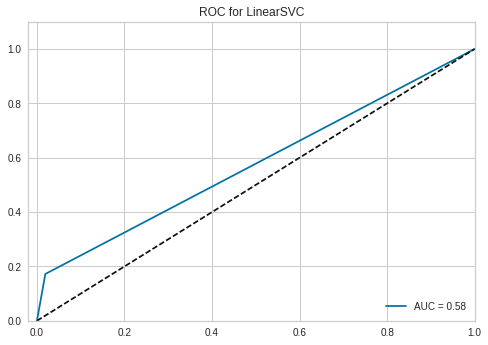

In [11]:
visualizer = ROCAUC(LinearSVC())
visualizer.fit(mydata,y)
visualizer.score(mydata,y)
visualizer.poof()